In [21]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Building DAG Hierarchy

**Goal: Group terms and find common name to create a hierarchy of DAG nodes from broad down to specific.**

Import Data
1. `dag_df` - Standardized DAG dataframe from workshop
2. `concept_df` - Athena concept dataframe containing all the athena ids, concept codes, and concept names
3. `concept_relationship_df` - Athena dataframe containing the relationships between all the concepts
4. `concept_ancestor_df` - Athena dataframe containing information on the ancestors of terms (unfortunately seems incomplete)

In [ ]:
dag_df = pd.read_csv('../data/DAGs_standardized.csv', dtype={'Exposure': str, 'Outcome':str})
concept_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT.csv', sep='\t', dtype={'concept_code': str, 'concept_id': str}, low_memory=False)
concept_relationship_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_RELATIONSHIP.csv', sep='\t', dtype={'concept_id_1':str, 'concept_id_2': str}, low_memory=False)
concept_ancestor_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_ANCESTOR.csv', sep='\t',dtype={'ancestor_concept_id': str, 'descendant_concept_id': str}, low_memory=False)

Get set of terms

In [3]:
from hierarchy_functions import get_unique_coded_terms

my_terms = get_unique_coded_terms(dag_df)

Dictionary to convert codes to names

In [4]:
code_to_name = dict(zip(concept_df["concept_id"], concept_df["concept_name"]))

### **Approach 1:** Using the parent and child relationships part of the OHDSI CDM / SNOMED CT ontology

First, let's explore what happens if we condense all child terms by associating them directly with their respective parent (root) terms within the terms that were part of the DAGs.

In [5]:
from hierarchy_functions import analyze_snomed_hierarchy

analysis_result = analyze_snomed_hierarchy(concept_ancestor_df, my_terms)
analysis_result

{'root_term_count': '129 out of 182 terms are root nodes',
 'average_children_per_root': 0.1,
 'example_root_with_children': {'root': '4103842', 'children': ['4306703']}}

In [6]:
# Example
print('Root term:', code_to_name[analysis_result['example_root_with_children']['root']])
print('Children:', [code_to_name[i] for i in analysis_result['example_root_with_children']['children']])

Root term: Arteriosclerosis
Children: ['Atherosclerosis']


It seems that even after doing so there are still a lot of different unique terms and we have to further group these into more broad categories to not overwhelm researchers. For this we will consider calcualting the distances from all the nodes to each other through a common ancestor node. This is important as nodes can have different parent terms and might otherwise link horizontally in a zig zag pattern instead of through a common ancestor higher up in the hierarchy.

There are a variety of relationship types available in the OHDSI Athena database. For now, we are using the "Subsumes" relationships that are the relationships that connect a parent term to a child term in the SNOMED CT hierarchy. However, more potentially useful relationship types are available like can be seen below.

In [7]:
useful_relationship_ids = [
    "Is a",                     # Hierarchical relationship of SNOMED
    "Subsumes",
    "Finding site of",          # Links findings to anatomical sites
    "Interprets of",             # Links specific measurements to conditions
    "Causative agent of",       # Etiological link
    "Has due to",               # Etiology relationships
    "Due to of",
    "Asso finding of",
    "Pathology of",             # Links to pathological processes
    "Has dir morph",            # Direct morphology
    "Has asso morph",           # Associated morphology
    "Occurs before",            # Temporal relationship
    "Follows",                  # Temporal relationship
    "Has manifestation",        # Links findings to manifestations
    "Has complication"          # Links to complications
]

selected_relationship_ids = ["Subsumes"]

Creating a graph structure of the terms based on SNOMED CT hierachy.

In [9]:
from hierarchy_functions import create_SNOMED_CT_graph_based_on_terms

G = create_SNOMED_CT_graph_based_on_terms(my_terms, concept_df, concept_relationship_df, selected_relationship_ids)

Number of nodes in graph of relevant SNOMED CT terms: 768
Number of edges in graph of relevant SNOMED CT terms: 1177
All terms are present in the graph.


Computing the least common ancestor between any two nodes part of my_terms and then the distance between the two terms going through that LCA.

In [11]:
from hierarchy_functions import compute_lcas_and_distances

lca_results = compute_lcas_and_distances(my_terms, G)

What are the most common "least common ancestors" between terms?

In [16]:
from collections import Counter

lca_counts = Counter(lca_results[0].values())
lca_counts_df = pd.DataFrame.from_dict(lca_counts, orient='index').reset_index()
lca_counts_df.columns = ['athena_code', 'count']
lca_counts_df = lca_counts_df.sort_values('count', ascending=False)
lca_counts_df['concept_name'] = [code_to_name[i] for i in lca_counts_df['athena_code']]
lca_counts_df.head(10)

,athena_code,count,concept_name
0,4008453,10707,SNOMED CT Concept
5,441840,2789,Clinical finding
6,4274025,779,Disease
10,134057,325,Disorder of cardiovascular system
25,4322976,271,Procedure
9,4180628,238,Disorder of body system
71,4029205,186,Procedure by method
14,4094294,160,Clinical history and observation findings
64,4181663,122,Observable entity
8,321588,85,Heart disease


Creating a distance matrix for the terms.

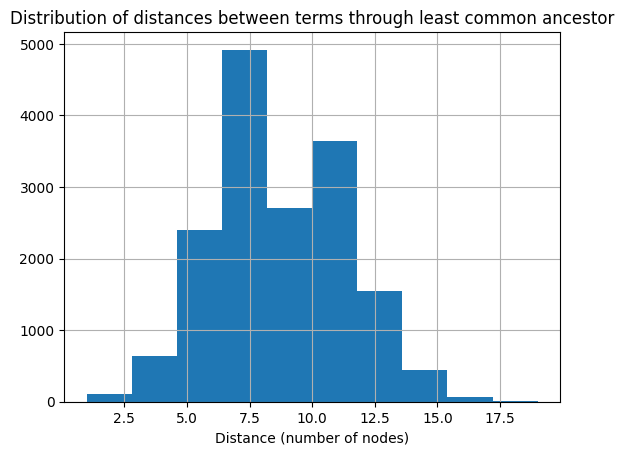

In [24]:
terms = sorted(my_terms)
distance_matrix = pd.DataFrame(index=terms, columns=terms, data=float('inf'))

for (term1, term2), distance in lca_results[1].items():
    distance_matrix.at[term1, term2] = distance
    distance_matrix.at[term2, term1] = distance
for term in my_terms:
    distance_matrix.at[term, term] = 0

distance_matrix.to_csv('snomed_distance_matrix.csv')
pd.Series(lca_results[1].values()).hist()
plt.title('Distribution of distances between terms through least common ancestor')
plt.xlabel('Distance (number of nodes)');